In [3]:
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np
from imutils import perspective
import imutils
import pandas as pd

In [1]:
## UNCOMMENT to use a circle to approximate map
# x = np.linspace(0,3,25)
# r = 150
# plt.plot(r * np.cos(x),r* np.sin(x),'o')
# plt.plot(-r * np.cos(x),-r* np.sin(x),'o')
# plt.axis('equal')
# plt.show()

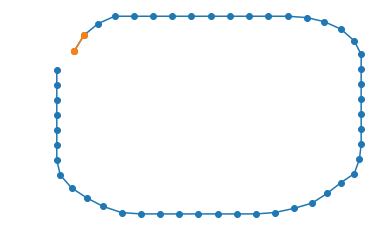

In [4]:
#Read from CSV of known map
data = pd.read_csv('map.csv', index_col = 0)
data['x'] = data['abs_x']
data['y'] = data['abs_y']
plt.plot(data['x'],data['y'],'-o')
plt.plot(data['x'][:2],data['y'][:2],'-o')
plt.axis('off')
plt.show()

car (17, 30)
estimated car (28.954438027691968, 22.555572152667573)
(27, 40)
(46, 51)


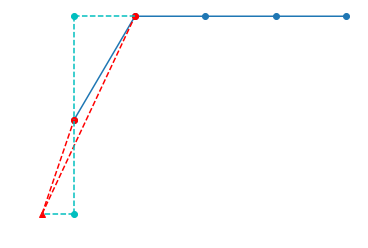

In [5]:
# How state estimation should work in simulation with added noise
count =2
 
C = data['x'][count]  -10,data['y'][count] -10

A = data['x'][count] ,data['y'][count]
B = data['x'][count+1] ,data['y'][count+1]
D = (A[0], B[1])
E = (A[0], C[1])


noise1 = np.random.uniform(-4,4)
noise2 = np.random.uniform(-4,4)
ac = np.sqrt( (A[0]- C[0])**2 + (A[1] - C[1])**2) + noise1
cb = np.sqrt( (C[0]- B[0])**2 + (C[1] - B[1])**2) + noise2

ab = np.sqrt( (A[0]- B[0])**2 + (A[1] - B[1])**2)

db = abs(D[0] - B[0]) 
da = abs(D[1] - A[1])

if ( ab**2 + ac**2 -(cb**2))/(2*ab*ac) < -1:
    alpha = np.arccos( -0.99 )
else:
    alpha = np.arccos( ( ab**2 + ac**2 -(cb**2))/(2*ab*ac))

theta = np.arcsin(db/ab)
psi = np.pi - alpha - theta

ae = np.sin(psi) * ac + A[0]
ec = -np.cos(psi) * ac + A[1]

print("car", C)
print("estimated car", (ae,ec))

plt.plot(data['x'][count:count+5],data['y'][count:count+5],'-o')

plt.plot(A[0],A[1], 'ro')
plt.plot(B[0],B[1], 'ro')
plt.plot(C[0],C[1],'r^')

plt.plot([C[0], A[0]],[C[1], A[1]],'r--')
plt.plot([C[0], B[0]],[C[1], B[1]],'r--')

plt.plot(D[0],D[1],'co')

plt.plot([D[0], A[0]],[D[1], A[1]],'c--')
plt.plot([D[0], B[0]],[D[1], B[1]],'c--')

plt.plot(E[0],E[1], 'co')
plt.plot([E[0],C[0]],[E[1],C[1]], 'c--')
plt.plot([E[0],A[0]],[E[1],A[1]], 'c--')

print(A)
print(B)
plt.axis('off')
plt.show()

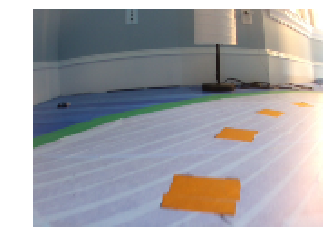

In [36]:
images = []
for path in sorted(os.listdir('data/statespace/images/')):
    im = cv2.imread('data/statespace/images/'+ path)
    images.append(im)
    
plt.imshow(images[10], cmap='gray')
plt.axis('off')
plt.show()


In [40]:
def estimate_position(width, centroid, count):
    
    distances = []
    angles = []
    positions = []
    
    f = 127.50 # PIXELS
    W = 7 # CM
    half_x = 80
    full_y = 120
    
    angles = []
    positions = []

    for w, (x,y) in zip(width, centroid):

        d = f* W / w # PIXELS

        if d > 130:
            d = 130
        distances.append(d)
        
        y_new_coord = full_y - y
        x_new_coord = x - half_x

        angle = np.arctan(x_new_coord/y_new_coord) 
        angles.append(angle* 180/np.pi)
        
        position = np.sin(angle) * d, np.cos(angle) * d
        positions.append(position)
   
    if (np.abs(angles[0]) < 5 and np.abs(angles[0] - angles[1]) < 5 or count > 47): #close enough to being in a straight line
        return data['x'][count] - positions[0][0], data['y'][count] - positions[0][1]


    distances = sorted(distances,reverse=False)

    A = (data['x'][count +1] , data['y'][count +1])
    B = (data['x'][count +2] , data['y'][count +2])
    D = (A[0], B[1])

    ac = distances[0]
    cb = distances[1]
    
    ab = np.sqrt( (A[0]- B[0])**2 + (A[1] - B[1])**2)

    db = abs(D[0] - B[0]) 
    da = abs(D[1] - A[1])

    if ( ab**2 + ac**2 -(cb**2))/(2*ab*ac) < -1:
        alpha = np.arccos( -0.99 )
    else:
        alpha = np.arccos( ( ab**2 + ac**2 -(cb**2))/(2*ab*ac))
        
    theta = np.arcsin(db/ab)

    psi = np.pi - alpha - theta

    ae = np.sin(psi) * ac - A[1]
    ec = -np.cos(psi) * ac - A[0]
    
    x = np.sin(psi) * ac + A[0]
    y = -np.cos(psi) * ac + A[1]
    
    return x,y

In [ ]:
video = True
if video:
    video_name = 'counting1.avi'
    height, width, layers = 288, 864, 3
    video = cv2.VideoWriter(video_name, -1,10, (width,height))

count = 0
prev_in_between = True
for i, img in enumerate(images):
    
    lower_blue = np.array([100,100,100])
    upper_blue = np.array([110,255,255])

    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, lower_blue, upper_blue)

    #Code to find the boxes:
    major = cv2.__version__.split('.')[0] 
    if major == '3':
        _, contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    else:
        contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    X = []
    Y = []
    width = []

    for c in contours:

        box = cv2.minAreaRect(c)
        box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
        box = np.array(box, dtype="int")

        # order the points in the contour such that they appear
        # in top-left, top-right, bottom-right, and bottom-left
        # order, then draw the outline of the rotated bounding
        # box
        box = perspective.order_points(box)
        cv2.drawContours(mask, [box.astype("int")], -1, (125), 2)

        width.append(box[1][0] - box[0][0])

        # calculate moments for each contour

        M = cv2.moments(c)

        # calculate x,y coordinate of center
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
        else:
            cX = (box[1][0] + box[0][0])//2
            cY = (box[1][1] + box[0][1])//2

        X.append(cX)
        Y.append(cY)

    if np.sum(mask[-10:,:])>0:
        in_between = False 
    else:
        in_between = True 

    if not prev_in_between and in_between:
        count += 1 
    if count > 49:
        break

    cur_x,cur_y = estimate_position(width,zip(X,Y), count)
    

    prev_in_between = in_between
    mask = np.stack((mask,)*3, axis=-1)
    cv2.putText(mask, "(" + str(round(cur_x,1)) +", "+ str(round(cur_y,1)) + ") ", (0,50), cv2.FONT_HERSHEY_SIMPLEX, 0.4, 255)
    if count  < 48:
        cv2.putText(mask,str(count) + " (" + str(round(data['x'][count+1], 2)) +", "+ str(round(data['y'][count+1],2)) + ") ", (0,110), cv2.FONT_HERSHEY_SIMPLEX, 0.4, 255)
    else:
        cv2.putText(mask,str(count), (0,110), cv2.FONT_HERSHEY_SIMPLEX, 0.4, 255)



    if video:
        fig = plt.figure()
        
    else:
        plt.figure()
        plt.subplot(1,2,1)
        plt.imshow(mask)
        plt.subplot(1,2,2)
        
    plt.plot(data['x'][count:count+5], data['y'][count:count+5], 'o-') 
    plt.plot(data['x'][:count+1], data['y'][:count+1], 'o-')

    # C
    plt.plot(cur_x,cur_y,'r^')
    if count  < 47:
        # A and B
        plt.plot(data['x'][count+1], data['y'][count+1], 'bo') 
        plt.plot(data['x'][count+2], data['y'][count+2], 'bo') 

        # Triangle ABC
        plt.plot([cur_x,data['x'][count+1]], [cur_y,data['y'][count+1]],  'r--')
        plt.plot([cur_x,data['x'][count+2]], [cur_y,data['y'][count+2]],  'r--')

        # Triangle ABD
        plt.plot([data['x'][count+1],data['x'][count+1]], [data['y'][count+1],data['y'][count+2]],  'g--')
        plt.plot([data['x'][count+1],data['x'][count+2]], [data['y'][count+2],data['y'][count+2]],  'g--')

        # Triangle ACE
        plt.plot([data['x'][count+1],data['x'][count+1]], [cur_y,data['y'][count+1]],  'c--')
        plt.plot([cur_x,data['x'][count+1]], [cur_y,cur_y],  'c--')

    if video:
        fig.canvas.draw()
        plot = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8,sep='')
        plot  = plot.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        plot = cv2.cvtColor(plot,cv2.COLOR_RGB2BGR)
        mask = cv2.resize(mask, (432,288))
        final = np.concatenate((mask, plot), axis=1)

        video.write(final)
    else:
        plt.show()

if video:
    cv2.destroyAllWindows()
    video.release()